# **Implémentation du modèle**
---

## Introduction

Contrairement au notebook "modèle", ici nous nous intéressons aux chocs de la politique monétaire américaine sur les pays européens.



Ce notebook contient les codes nécessaire à la mise en place du modèle. Le modèle est inspiré de celui de Iacoviello et Navarro : 

- La première étape consiste à identifier les chocs de politique monétaire, en prenant le résidu de la régression du taux d'intérêt sur l'écart d'inflation par rapport à la cible et l'output gap ou le chômage. En réalité Iacoviello et Navarro utilisent des lags et valeurs présentes de l'inflation, des spreads de crédit, du PIB et des lags des taux des fonds fédéraux.
Il nous manque donc l'output gap, l'inflation et le chômage de la zone euro
- La deuxième étape consiste à estimer l'impact de ces chocs sur l'activité économique (PIB, emploi ...) en régressant ces variables sur les chocs et des variables de contrôles (4 lags du PIB et des trends linéaires et quadratiques)

## Formatage des données

In [1]:
# import des données américaines

!pip install openpyxl 
import pandas as pd

sheets_to_load = ["Daily, Close", "Monthly", "Quarterly"]  # Noms des feuilles à importer
dfs = pd.read_excel("../Données_extraites/data_US.xlsx", sheet_name=sheets_to_load, header=0)
# Accéder aux DataFrames importés
dfD = dfs["Daily, Close"]
dfM = dfs["Monthly"]
dfQ = dfs["Quarterly"]

# renommer les variables
dfD.columns = dfD.iloc[0] 
dfD = dfD[1:].reset_index(drop=True)

dfM.columns = dfM.iloc[0] 
dfM = dfM[1:].reset_index(drop=True)


# Il faut trimestrialiser les données (on prend la moyenne)

dfM["date"] = pd.to_datetime(dfM["date"])  # Convertir en datetime
dfM = dfM.set_index("date")  # Définir la colonne "date" comme index
dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre

dfD["date"] = pd.to_datetime(dfD["date"])  # Convertir en datetime
dfD = dfD.set_index("date")  # Définir la colonne "date" comme index
dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre

# harmoniser les dates
dfD_Q.index = dfD_Q.index.to_period("Q")  
dfM_Q.index = dfM_Q.index.to_period("Q")

dfQ=dfQ.rename(columns={"observation_date":"date"})
dfQ = dfQ.set_index("date")
dfQ.index = dfQ.index.to_period("Q")



/tmp/ipykernel_4745/4245104104.py:25: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre
/tmp/ipykernel_4745/4245104104.py:29: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre


In [2]:
import numpy as np
data_US = dfM_Q.merge(dfD_Q, on='date').merge(dfQ, on='date')

# Créer la variable d'inflation (sur 4 trimestres)
data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage

# Créer une variable de temps et tendnce quadratique
data_US['time'] = range(1, len(data_US) + 1)
data_US['time_squared'] = data_US['time'] ** 2

# Créer 4 lags pour chaque variable
for col in data_US.columns:
    for lag in range(1, 5):  # Créer les lags 1, 2, 3, 4
        data_US[f"{col}_lag{lag}"] = data_US[col].shift(lag)


# Filtrer les colonnes contenant 'GDP'
gdp_columns = [col for col in data_US.columns if 'GDP' in col]

# Créer de nouvelles colonnes en log pour chaque colonne contenant 'GDP'
for col in gdp_columns:
    data_US[f"{col}_log"] = np.log(data_US[col])



/tmp/ipykernel_4745/3975620391.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage


In [3]:
data_US

,CPI,Policy rate,Industrial production,activité mensualisée,spread corporate,GDPC1,inflation,time,time_squared,CPI_lag1,...,time_lag4,time_squared_lag1,time_squared_lag2,time_squared_lag3,time_squared_lag4,GDPC1_log,GDPC1_lag1_log,GDPC1_lag2_log,GDPC1_lag3_log,GDPC1_lag4_log
date,,,,,,,,,,,,,,,,,,,,,
1996Q4,158.666667,5.28,76.830067,99.577753,0.6,12037.775,NaN,1,1,None,...,NaN,NaN,NaN,NaN,NaN,9.395805,NaN,NaN,NaN,NaN
1997Q1,159.633333,5.276667,78.286233,99.592907,0.591475,12115.472,NaN,2,4,158.666667,...,NaN,1.0,NaN,NaN,NaN,9.402239,9.395805,NaN,NaN,NaN
1997Q2,160.0,5.523333,79.403833,99.823247,0.584615,12317.221,NaN,3,9,159.633333,...,NaN,4.0,1.0,NaN,NaN,9.418754,9.402239,9.395805,NaN,NaN
1997Q3,160.8,5.533333,81.2606,100.017223,0.568308,12471.010,NaN,4,16,160.0,...,NaN,9.0,4.0,1.0,NaN,9.431162,9.418754,9.402239,9.395805,NaN
1997Q4,161.666667,5.506667,83.325533,100.0244,0.667273,12577.495,1.890756,5,25,160.8,...,1.0,16.0,9.0,4.0,1.0,9.439664,9.431162,9.418754,9.402239,9.395805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q4,308.158333,5.33,102.6986,100.44725,1.194923,22960.600,3.236199,109,11881,306.042333,...,105.0,11664.0,11449.0,11236.0,11025.0,10.041535,10.033679,10.023021,10.016970,10.010073
2024Q1,310.974333,5.33,102.242767,NaN,0.987969,23053.545,3.247987,110,12100,308.158333,...,106.0,11881.0,11664.0,11449.0,11236.0,10.045575,10.041535,10.033679,10.023021,10.016970
2024Q2,313.095667,5.33,102.8633,NaN,0.914394,23223.906,3.187395,111,12321,310.974333,...,107.0,12100.0,11881.0,11664.0,11449.0,10.052937,10.045575,10.041535,10.033679,10.023021


## Détermination des chocs

In [4]:
data_US.columns

Index(['CPI', 'Policy rate', 'Industrial production', 'activité mensualisée',
       'spread corporate', 'GDPC1', 'inflation', 'time', 'time_squared',
       'CPI_lag1', 'CPI_lag2', 'CPI_lag3', 'CPI_lag4', 'Policy rate_lag1',
       'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
       'Industrial production_lag1', 'Industrial production_lag2',
       'Industrial production_lag3', 'Industrial production_lag4',
       'activité mensualisée_lag1', 'activité mensualisée_lag2',
       'activité mensualisée_lag3', 'activité mensualisée_lag4',
       'spread corporate_lag1', 'spread corporate_lag2',
       'spread corporate_lag3', 'spread corporate_lag4', 'GDPC1_lag1',
       'GDPC1_lag2', 'GDPC1_lag3', 'GDPC1_lag4', 'inflation_lag1',
       'inflation_lag2', 'inflation_lag3', 'inflation_lag4', 'time_lag1',
       'time_lag2', 'time_lag3', 'time_lag4', 'time_squared_lag1',
       'time_squared_lag2', 'time_squared_lag3', 'time_squared_lag4',
       'GDPC1_log', 'GDPC1_lag1_log',

### 1er essai : modèle avec 4 lags

In [5]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean=data_US_clean.apply(pd.to_numeric, errors='coerce')
# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes sauf 'key_rate' et 'TIME_PERIOD'
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
'inflation','inflation_lag1','inflation_lag2', 'inflation_lag3', 'inflation_lag4',
'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log','GDPC1_lag4_log',
'spread corporate','spread corporate_lag1', 'spread corporate_lag2','spread corporate_lag3', 'spread corporate_lag4',
'time_squared']]



# Ajouter une constante pour l'intercept dans la régression
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks'] = model.resid

# Afficher le résumé de la régression
print(model.summary())


with open("regression_results4 US.tex", "w") as f:
    f.write(model.summary().as_latex())

    
# Sauvegarder les résultats dans un fichier CSV
data_US_clean[['time', 'monetary_shocks']].to_csv('identified_monetary_shocks.csv', index=False)

# Exporter les résultats de la régression en latex
with open("regression_results_US.tex", "w") as f:
    f.write(model.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     280.2
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           1.58e-65
Time:                        07:45:41   Log-Likelihood:                 1.2524
No. Observations:                 101   AIC:                             39.50
Df Residuals:                      80   BIC:                             94.41
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.18

In [6]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1', 'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
                   'inflation', 'inflation_lag1', 'inflation_lag2', 'inflation_lag3', 'inflation_lag4',
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log', 'GDPC1_lag4_log',
                   'spread corporate', 'spread corporate_lag1', 'spread corporate_lag2', 
                   'spread corporate_lag3', 'spread corporate_lag4', 'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks'] = model.resid

# Fonction pour ajouter les étoiles de significativité
def significance_stars(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.1:
        return '*'
    else:
        return ''

# Appliquer la fonction avant de formater les nombres
p_values = model.pvalues.apply(significance_stars)

# Créer un DataFrame des résultats
results_df = pd.DataFrame({
    'Coefficient': model.params.map('{:.4f}'.format) + p_values,
    'Std. Error': model.bse.map('{:.4f}'.format),
    't-Statistic': model.tvalues.map('{:.4f}'.format),
    'P-Value': model.pvalues.map('{:.4f}'.format),
})

# Reformater les résultats pour summary_col
model_summary = summary_col([model], stars=True, float_format="%.4f",
                            model_names=["Régression"],
                            info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}",
                                       'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}",
                                       'F-statistic': lambda x: f"{x.fvalue:.2f} (p={x.f_pvalue:.4g})"})

# Exporter le tableau en LaTeX
latex_table = model_summary.as_latex()

with open("regression_results_full_US.tex", "w") as f:
    f.write(latex_table)

# Affichage du tableau final
print(model_summary)


                           Régression    
-----------------------------------------
const                 0.1814             
                      (8.7748)           
Policy rate_lag1      1.6687***          
                      (0.1167)           
Policy rate_lag2      -0.7024***         
                      (0.2355)           
Policy rate_lag3      -0.1986            
                      (0.2396)           
Policy rate_lag4      0.1693             
                      (0.1263)           
inflation             0.0569             
                      (0.0436)           
inflation_lag1        -0.0207            
                      (0.0643)           
inflation_lag2        0.0168             
                      (0.0640)           
inflation_lag3        0.0110             
                      (0.0639)           
inflation_lag4        0.0210             
                      (0.0453)           
GDPC1_log             5.9692**           
                      (2.7764)   

### 2ème essai: modèle avec 2 lags

In [7]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   'inflation','inflation_lag1','inflation_lag2', 
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   'spread corporate','spread corporate_lag1', 'spread corporate_lag2',
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks'] = model.resid

# Ajouter les étoiles de significativité
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les résultats formatés
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les étoiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# Réorganiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au début
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags.tex", "w") as f:
    f.write(latex_table)

# Afficher le résumé de la régression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     480.0
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           1.14e-74
Time:                        07:45:45   Log-Likelihood:                -2.1134
No. Observations:                 101   AIC:                             30.23
Df Residuals:                      88   BIC:                             64.22
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.61

#### Lissage exponentiel de la série pour mieux identifier les chocs

#### Lissage en moyenne glissante

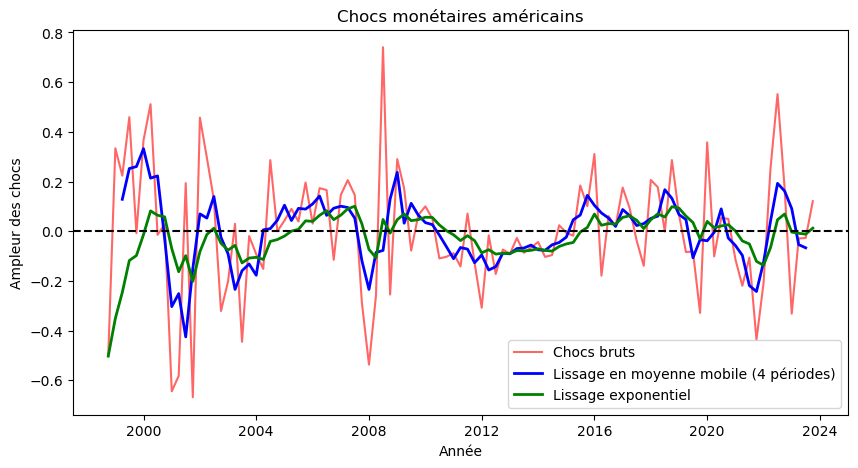

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 périodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks'].ewm(span=10, adjust=False).mean()

# Tracer les séries
plt.figure(figsize=(10,5))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks'], color='red', alpha=0.6, label='Chocs bruts')  # Série brute
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Lissage en moyenne mobile (4 périodes)')  # Série lissée
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")  # Ligne de base
plt.xlabel('Année')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs monétaires américains')
plt.legend()
plt.savefig("monetary_shocks.png", dpi=300)  
plt.show()

## 2ème partie du modèle: impact des chocs sur les pays européens

Nous allons maintenant estimer avec une régression de panel l'impact des chocs de politique monétaire identifiés, sur différentes variables (GDP, employment ? ...). La méthode utilisé est celle de Jorda (2005), la méthode de projection locale. Cela consiste à "estimer des projections locales à chaque période au lieu d'extrapoler sur des horizons lointains à partir d'un modèle."
Nous allons estimer une équation de la forme suivante, comme dans Iacoviello & Navarro (2018) :

$$
y_{i,t+h} = \alpha_{i,h} + \beta_h u_t + A_{h,i} Z_{i,t} + \varepsilon_{i,t+h}
$$

où :

- $y_{i,t+h}$ est le PIB du pays $ i $ au temps $t$,
- $\alpha_{i,h} $ est un effet fixe spécifique au pays,
- $u_t$ est le choc monétaire,
- $Z_{i,t}$  représente les variables de contrôle : 4 lags du PIB, des tendances linéaire et quadratique,
- $\varepsilon_{i,t+h}$  est le terme d'erreur.

Pour chaque h il faut estimer un $\beta_h$, ensuite il faut faire les IRF (fonctions de réponse impulsionnelle) pour les différents Y qu'on utilise.


Pour les variables de contrôle, il faut sûrement tester lesquelles sont les meilleures, ne pas forcément reproduire exactement le modèle.

On a des données trimestrielles donc on prend h de 0 à 4 ou 8

In [157]:
import pandas as pd
data=pd.read_excel("../Données_produites/base_de_données_v1.xlsx")

In [158]:
# 🔍 Étape 1 : Vérification des colonnes
print("Colonnes initiales :", data.columns.tolist())

# Identifier automatiquement la colonne temporelle si nommée "Unnamed: 0" ou similaire
time_col_candidates = [col for col in data.columns if "unnamed" in col.lower() or "time" in col.lower()]
if time_col_candidates:
    time_col = time_col_candidates[0]
    data = data.rename(columns={time_col: "Time"})
else:
    raise ValueError("Impossible de trouver la colonne 'Time' dans le fichier Excel.")

# 🔁 Étape 2 : Conversion au format long
df_long = data.melt(id_vars="Time", var_name="Variable_Country", value_name="Value")

# 🔍 Étape 3 : Vérification du format des noms
# Affiche quelques exemples pour s’assurer du format attendu
print("\nExemples de noms de colonnes fusionnées :", df_long["Variable_Country"].unique()[:5])

# Appliquer un split seulement si un underscore est présent
split_ok = df_long["Variable_Country"].str.contains("_")
df_valid = df_long[split_ok].copy()

# Séparer en deux colonnes : Variable + Country
df_valid[["Variable", "Country"]] = df_valid["Variable_Country"].str.rsplit("_", n=1, expand=True)

# ⚠️ Facultatif : alerter sur les noms qui n'ont pas pu être séparés
if not split_ok.all():
    print("Colonnes ignorées car mal nommées :", df_long.loc[~split_ok, "Variable_Country"].unique())

# Réorganiser les colonnes
df_final = df_valid[["Time", "Country", "Variable", "Value"]]

# ✅ Affichage final
print("\nAperçu du DataFrame long format :")
print(df_final.head())

# Sauvegarde dans data pour compatibilité avec le reste de ton notebook
data = df_final.copy()


Colonnes initiales : ['Unnamed: 0', 'CPI_Austria', 'PIB_Austria', 'LT_IR_Austria', 'ST_IR_Austria', 'WH_Austria', 'P_Growth_Austria', 'CPI_Belgium', 'PIB_Belgium', 'LT_IR_Belgium', 'ST_IR_Belgium', 'WH_Belgium', 'P_Growth_Belgium', 'CPI_Bulgaria', 'PIB_Bulgaria', 'LT_IR_Bulgaria', 'ST_IR_Bulgaria', 'WH_Bulgaria', 'P_Growth_Bulgaria', 'CPI_Czechia', 'PIB_Czechia', 'LT_IR_Czechia', 'ST_IR_Czechia', 'WH_Czechia', 'P_Growth_Czechia', 'CPI_Denmark', 'PIB_Denmark', 'LT_IR_Denmark', 'ST_IR_Denmark', 'WH_Denmark', 'P_Growth_Denmark', 'CPI_Estonia', 'PIB_Estonia', 'LT_IR_Estonia', 'ST_IR_Estonia', 'WH_Estonia', 'P_Growth_Estonia', 'CPI_Finland', 'PIB_Finland', 'LT_IR_Finland', 'ST_IR_Finland', 'WH_Finland', 'P_Growth_Finland', 'CPI_France', 'PIB_France', 'LT_IR_France', 'ST_IR_France', 'WH_France', 'P_Growth_France', 'CPI_Germany', 'PIB_Germany', 'LT_IR_Germany', 'ST_IR_Germany', 'WH_Germany', 'P_Growth_Germany', 'CPI_Greece', 'PIB_Greece', 'LT_IR_Greece', 'ST_IR_Greece', 'WH_Greece', 'P_Growth

In [159]:
# merger les données des pays avec les chocs
# Il faudrait mettre les données en format long pour faire le modèle (1 colonne pays, 1 colonne time et 1 colonne par variable)

In [160]:
print(data.head)

<bound method NDFrame.head of           Time  Country         Variable      Value
0      1995-Q1  Austria              CPI        NaN
1      1995-Q2  Austria              CPI        NaN
2      1995-Q3  Austria              CPI        NaN
3      1995-Q4  Austria              CPI        NaN
4      1996-Q1  Austria              CPI  71.553333
...        ...      ...              ...        ...
20155  2023-Q4  Kingdom  P_Growth_United        NaN
20156  2024-Q1  Kingdom  P_Growth_United        NaN
20157  2024-Q2  Kingdom  P_Growth_United        NaN
20158  2024-Q3  Kingdom  P_Growth_United        NaN
20159  2024-Q4  Kingdom  P_Growth_United        NaN

[20160 rows x 4 columns]>


In [161]:
# Liste triée des valeurs uniques dans la colonne "Variable"
valeurs_variable = sorted(data["Variable"].dropna().unique().tolist())

# Affichage propre
print("🧾 Liste des variables disponibles :")
for var in valeurs_variable:
    print("-", var)

🧾 Liste des variables disponibles :
- CPI
- CPI_United
- LT_IR
- LT_IR_United
- PIB
- PIB_United
- P_Growth
- P_Growth_United
- ST_IR
- ST_IR_United
- WH
- WH_United


Réponse du PIB américain aux chocs

In [162]:
df = data_US_clean.copy()

# 2. Définir les lags du PIB
for lag in range(1, 5):
    df[f'GDP_lag{lag}'] = df['GDPC1_log'].shift(lag)

# 3. Ajouter la tendance quadratique
df['trend'] = range(len(df))
df['trend_sq'] = df['trend'] ** 2

# 4. Supprimer les lignes avec NaN (causées par les lags)
df_model = df.dropna(subset=['GDPC1_log', 'monetary_shocks', 'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4'])

# 5. Variables dépendante et explicatives
Y = df_model['GDPC1_log']  # ou un horizon de forecast y_{t+h} si tu décales Y
X = df_model[['monetary_shocks', 'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4', 'trend', 'trend_sq']]
X = sm.add_constant(X)

# 6. Régression
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              GDPC1_log   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1648.
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           2.97e-91
Time:                        14:21:11   Log-Likelihood:                 290.23
No. Observations:                  97   AIC:                            -564.5
Df Residuals:                      89   BIC:                            -543.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6789      0.658     

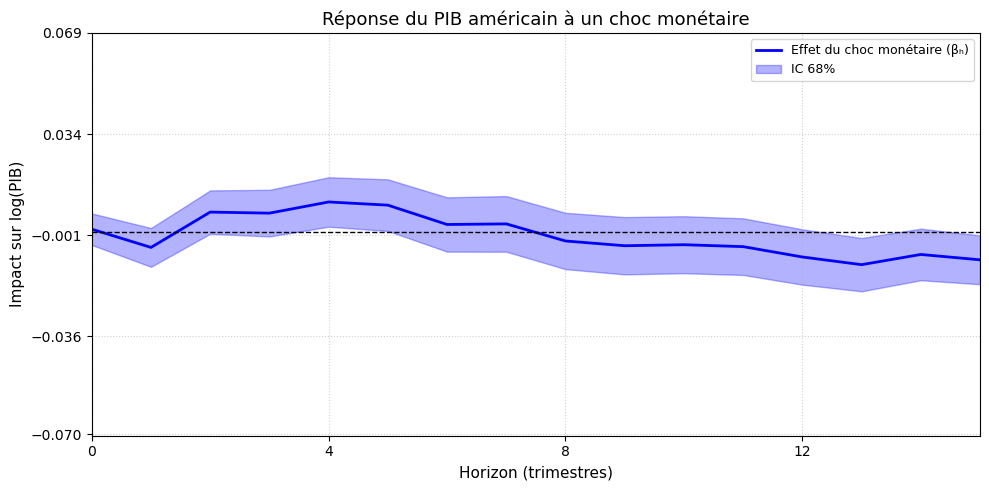

In [163]:
# Paramètres
H = 15  # nombre d'horizons (trimestres)
betas = []
stderr_list = []

# Boucle sur les horizons h = 0 à H
for h in range(H + 1):
    df = data_US_clean.copy()

    # Création des lags du PIB
    for lag in range(1, 5):
        df[f'GDP_lag{lag}'] = df['GDPC1_log'].shift(lag)

    # Tendance quadratique
    df['trend'] = range(len(df))
    df['trend_sq'] = df['trend'] ** 2

    # Variable dépendante : PIB à l’horizon h
    df[f'GDP_lead{h}'] = df['GDPC1_log'].shift(-h)

    # Nettoyage
    df_model = df.dropna(subset=[f'GDP_lead{h}', 'monetary_shocks',
                                 'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4'])

    Y = df_model[f'GDP_lead{h}']
    X = df_model[['monetary_shocks', 'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4', 'trend', 'trend_sq']]
    X = sm.add_constant(X)

    model = sm.OLS(Y, X).fit()

    # Stockage du coefficient et de l'écart-type
    beta = model.params['monetary_shocks']
    stderr = model.bse['monetary_shocks']

    betas.append(beta)
    stderr_list.append(stderr)

# Calcul de l’intervalle de confiance à 68%
lower = [b - s for b, s in zip(betas, stderr_list)]
upper = [b + s for b, s in zip(betas, stderr_list)]

# 📐 Définir les bornes dynamiquement avec une petite marge
y_min = min(lower) - 0.05
y_max = max(upper) + 0.05

# Tracé de l'IRF
plt.figure(figsize=(10, 5))
plt.plot(range(H + 1), betas, color='blue', linewidth=2, label="Effet du choc monétaire (βₕ)")
plt.fill_between(range(H + 1), lower, upper, color='blue', alpha=0.3, label="IC 68%")
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("Réponse du PIB américain à un choc monétaire", fontsize=13)
plt.xlabel("Horizon (trimestres)", fontsize=11)
plt.ylabel("Impact sur log(PIB)", fontsize=11)

# ✅ Axes dynamiques + style propre
plt.ylim(y_min, y_max)
plt.xlim(0, H)
plt.xticks(np.arange(0, H+1, 4))
plt.yticks(np.round(np.linspace(y_min, y_max, 5), 3))

plt.legend(loc="best", fontsize=9)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


Réponses des taux obligataires/corpo aux chocs

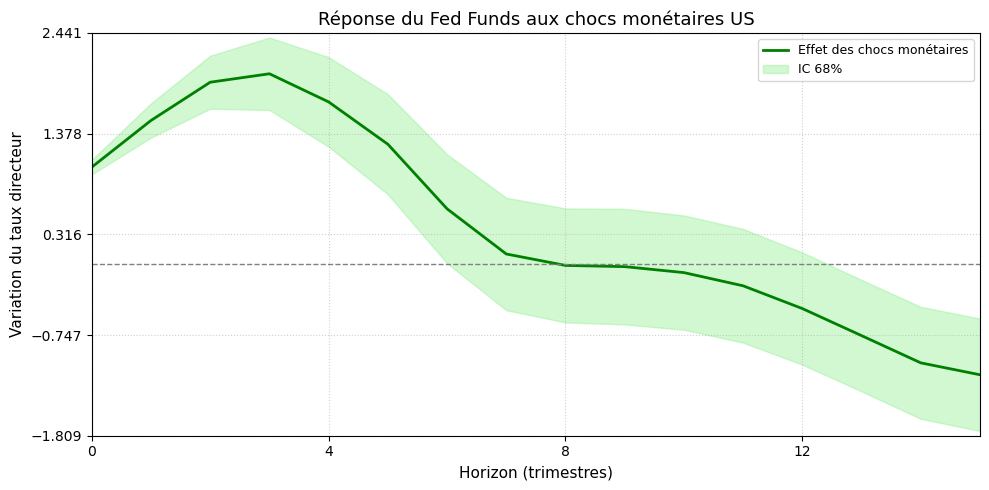

In [164]:
# Horizon maximal
H = 15  # trimestres

# Stockage des résultats
betas = []
stderr_list = []

# Boucle sur chaque horizon h
for h in range(H + 1):
    df = data_US_clean.copy()

    # Ajouter les lags du taux directeur
    for lag in range(1, 5):
        df[f'rate_lag{lag}'] = df['Policy rate'].shift(lag)

    # Tendance quadratique
    df['trend'] = range(len(df))
    df['trend_sq'] = df['trend'] ** 2

    # Variable dépendante : taux directeur à horizon h
    df[f'rate_lead{h}'] = df['Policy rate'].shift(-h)

    # Nettoyage
    df_model = df.dropna(subset=[f'rate_lead{h}', 'monetary_shocks',
                                 'rate_lag1', 'rate_lag2', 'rate_lag3', 'rate_lag4'])

    Y = df_model[f'rate_lead{h}']
    X = df_model[['monetary_shocks', 'rate_lag1', 'rate_lag2', 'rate_lag3', 'rate_lag4', 'trend', 'trend_sq']]
    X = sm.add_constant(X)

    model = sm.OLS(Y, X).fit()

    # Stockage du coefficient et de l'écart-type
    beta = model.params['monetary_shocks']
    stderr = model.bse['monetary_shocks']

    betas.append(beta)
    stderr_list.append(stderr)

# Calcul de l’intervalle de confiance à 68%
lower = [b - s for b, s in zip(betas, stderr_list)]
upper = [b + s for b, s in zip(betas, stderr_list)]

# Définir les bornes dynamiques
y_min = min(lower) - 0.05
y_max = max(upper) + 0.05

# Tracé de l'IRF
plt.figure(figsize=(10, 5))
plt.plot(range(H + 1), betas, color='green', linewidth=2, label="Effet des chocs monétaires")
plt.fill_between(range(H + 1), lower, upper, color='lightgreen', alpha=0.4, label="IC 68%")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title("Réponse du Fed Funds aux chocs monétaires US", fontsize=13)
plt.xlabel("Horizon (trimestres)", fontsize=11)
plt.ylabel("Variation du taux directeur", fontsize=11)

plt.ylim(y_min, y_max)
plt.xlim(0, H)
plt.xticks(np.arange(0, H + 1, 4))
plt.yticks(np.round(np.linspace(y_min, y_max, 5), 3))

plt.legend(loc="best", fontsize=9)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


Réponse des PIBs des pays européens aux chocs

In [165]:
# --- 1. Préparer les chocs monétaires US ---
chocs = data_US_clean[["monetary_shocks"]].reset_index().rename(columns={"date": "Time"})
chocs["Time"] = chocs["Time"].astype(str)

# Standardiser : passer les deux au format "YYYYQx"
data["Time"] = data["Time"].str.replace("-", "").str.upper()  # '1995-Q1' → '1995Q1'
chocs["Time"] = pd.to_datetime(chocs["Time"]).dt.to_period("Q").astype(str).str.replace("-", "")

# --- 2. Nettoyer l'éventuel doublon dans data ---
if "monetary_shocks" in data.columns:
    data = data.drop(columns=["monetary_shocks"])

# --- 3. Fusionner proprement avec les données européennes longues ---
data = data.merge(chocs, on="Time", how="inner")

# --- 4. Filtrer la variable cible (ex : PIB) ---
target_variable = "PIB"
df_target = data[data["Variable"] == target_variable].copy()

# --- 5. Ajouter lags et tendances ---
df_target = df_target.sort_values(["Country", "Time"])
for lag in range(1, 5):
    df_target[f"lag{lag}"] = df_target.groupby("Country")["Value"].shift(lag)

df_target["trend"] = df_target.groupby("Country").cumcount() + 1
df_target["trend_sq"] = df_target["trend"] ** 2

# --- 6. Régressions pays par pays ---
results = {}

required_cols = ["Value", "monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]

for country in df_target["Country"].unique():
    sub = df_target[df_target["Country"] == country].dropna(subset=required_cols)

    if len(sub) < 10:
        continue  # Trop peu d'observations pour une régression fiable

    X = sub[["monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
    X = sm.add_constant(X)
    y = sub["Value"]

    model = sm.OLS(y, X).fit()
    results[country] = model

    coef = model.params["monetary_shocks"]
    pval = model.pvalues["monetary_shocks"]
    print(f"{country}: coef = {coef:.4f}, p-value = {pval:.4f}")

Austria: coef = -136.2315, p-value = 0.9086
Belgium: coef = -315.3053, p-value = 0.8159
Bulgaria: coef = 170.8036, p-value = 0.5553
Czechia: coef = 318.4367, p-value = 0.7524
Denmark: coef = 775.4767, p-value = 0.3310
Estonia: coef = 63.0457, p-value = 0.5859
Finland: coef = -254.9432, p-value = 0.6691
France: coef = -7493.5788, p-value = 0.2071
Germany: coef = -6142.2311, p-value = 0.3618
Greece: coef = 249.9841, p-value = 0.8122
Hungary: coef = -248.9843, p-value = 0.7597
Iceland: coef = 198.0388, p-value = 0.1668
Ireland: coef = 1148.0045, p-value = 0.4391
Italy: coef = -6314.6570, p-value = 0.3081
Latvia: coef = -12.8552, p-value = 0.9422
Lithuania: coef = -119.7716, p-value = 0.6095
Luxembourg: coef = -187.1505, p-value = 0.2903
Netherlands: coef = -1529.0389, p-value = 0.3353
Norway: coef = -2421.0577, p-value = 0.3993
Poland: coef = -83.8182, p-value = 0.9762
Portugal: coef = 289.0249, p-value = 0.6903
Romania: coef = 1135.9100, p-value = 0.3901
Slovakia: coef = -9.4254, p-value


📋 Résultats :
        Country  Coef_monetary_shock   P_value  R_squared
12      Ireland          1148.004458  0.439115   0.987825
21      Romania          1135.910043  0.390074   0.978176
4       Denmark           775.476653  0.330983   0.984986
3       Czechia           318.436659  0.752369   0.980517
20     Portugal           289.024878  0.690269   0.962656
9        Greece           249.984101  0.812220   0.893680
11      Iceland           198.038838  0.166778   0.954728
2      Bulgaria           170.803625  0.555276   0.985973
5       Estonia            63.045686  0.585859   0.987229
22     Slovakia            -9.425392  0.977332   0.989198
14       Latvia           -12.855159  0.942152   0.966846
19       Poland           -83.818248  0.976208   0.973512
23     Slovenia           -87.616539  0.614206   0.979052
15    Lithuania          -119.771577  0.609505   0.984293
0       Austria          -136.231496  0.908628   0.979566
25       Sweden          -163.065707  0.922110   0.972894

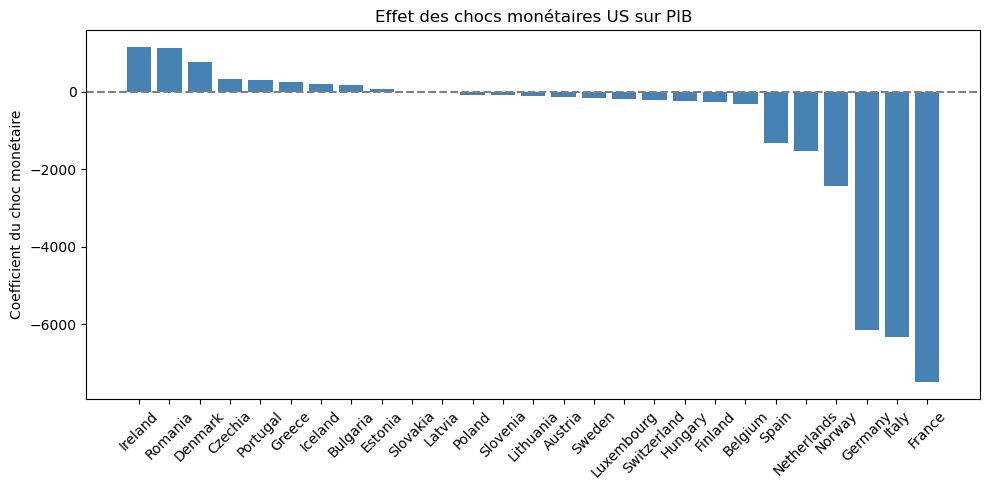

In [166]:
# --- 1. Filtrer les données ---
df_target = data[data["Variable"] == target_variable].copy()
df_target = df_target.sort_values(["Country", "Time"])

# --- 2. Ajouter les lags et tendances ---
for lag in range(1, 5):
    df_target[f"lag{lag}"] = df_target.groupby("Country")["Value"].shift(lag)

df_target["trend"] = df_target.groupby("Country").cumcount() + 1
df_target["trend_sq"] = df_target["trend"] ** 2

# --- 3. Régressions pays par pays ---
results = []
required_cols = ["Value", "monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]

for country in df_target["Country"].unique():
    sub = df_target[df_target["Country"] == country].dropna(subset=required_cols)

    if len(sub) < 10:
        continue

    X = sub[["monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
    X = sm.add_constant(X)
    y = sub["Value"]

    model = sm.OLS(y, X).fit()
    coef = model.params["monetary_shocks"]
    pval = model.pvalues["monetary_shocks"]

    results.append({
        "Country": country,
        "Coef_monetary_shock": coef,
        "P_value": pval,
        "R_squared": model.rsquared
    })

# --- 4. Affichage des résultats ---
results_df = pd.DataFrame(results).sort_values("Coef_monetary_shock", ascending=False)
print("\n📋 Résultats :")
print(results_df)

# --- 5. Graphique barplot ---
plt.figure(figsize=(10, 5))
plt.bar(results_df["Country"], results_df["Coef_monetary_shock"], color="steelblue")
plt.axhline(0, color="gray", linestyle="--")
plt.title(f"Effet des chocs monétaires US sur {target_variable}")
plt.ylabel("Coefficient du choc monétaire")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Avec la séparation en catégories

In [173]:
categories = {
    "Économie en développement": [
        "Czechia", "Lithuania", "Latvia", "Poland", "Bulgaria", "Slovakia",
        "Hungary", "Slovenia", "Iceland", "Estonia", "Romania"
    ],
    "Grosse économie développée": [
        "Germany", "United Kingdom", "France", "Italy", "Spain", "Netherlands"
    ],
    "Petite économie développée": [
        "Austria", "Belgium", "Denmark", "Greece", "Finland", "Ireland",
        "Luxembourg", "Norway", "Portugal", "Sweden", "Switzerland"
    ]
}



📋 Résultats par pays :
        Country                    Category  Coef_monetary_shock   P_value  \
11      Iceland   Économie en développement             0.085426  0.041632   
21      Romania   Économie en développement             0.038986  0.316412   
5       Estonia   Économie en développement             0.018986  0.401184   
3       Czechia   Économie en développement             0.014954  0.518123   
2      Bulgaria   Économie en développement             0.013737  0.563655   
14       Latvia   Économie en développement             0.011300  0.738042   
4       Denmark  Petite économie développée             0.010031  0.365857   
22     Slovakia   Économie en développement             0.009644  0.632594   
20     Portugal  Petite économie développée             0.008576  0.564816   
12      Ireland  Petite économie développée             0.008564  0.658008   
0       Austria  Petite économie développée            -0.000373  0.977322   
25       Sweden  Petite économie dévelop

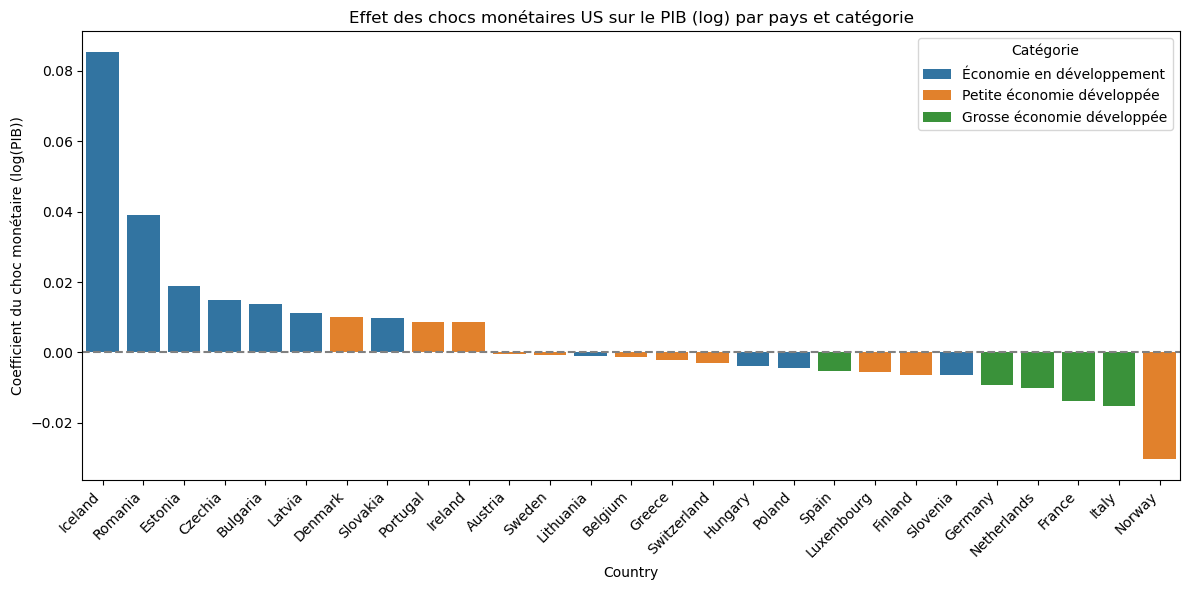

In [191]:
def get_category(country):
    for cat, countries in categories.items():
        if country in countries:
            return cat
    return "Autre"

# --- 2. Filtrer les données sur le PIB et prendre le log ---
target_variable = "PIB"
df_target = data[data["Variable"] == target_variable].copy()
df_target = df_target[df_target["Value"] > 0]  # sécurité pour log
df_target["Value"] = np.log(df_target["Value"])

# --- 3. Trier et ajouter lags + tendances ---
df_target = df_target.sort_values(["Country", "Time"])

for lag in range(1, 5):
    df_target[f"lag{lag}"] = df_target.groupby("Country")["Value"].shift(lag)

df_target["trend"] = df_target.groupby("Country").cumcount() + 1
df_target["trend_sq"] = df_target["trend"] ** 2
df_target["Category"] = df_target["Country"].apply(get_category)

# --- 4. Régressions pays par pays ---
results = []
required_cols = ["Value", "monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]

for country in df_target["Country"].unique():
    sub = df_target[df_target["Country"] == country].dropna(subset=required_cols)

    if len(sub) < 10:
        continue

    X = sub[["monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
    X = sm.add_constant(X)
    y = sub["Value"]

    model = sm.OLS(y, X).fit()
    coef = model.params["monetary_shocks"]
    pval = model.pvalues["monetary_shocks"]
    category = get_category(country)

    results.append({
        "Country": country,
        "Category": category,
        "Coef_monetary_shock": coef,
        "P_value": pval,
        "R_squared": model.rsquared
    })

# --- 5. Résultats ---
results_df = pd.DataFrame(results).sort_values("Coef_monetary_shock", ascending=False)

print("\n📋 Résultats par pays :")
print(results_df)

# --- 6. Graphique groupé par catégorie ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Country", y="Coef_monetary_shock", hue="Category", dodge=False)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Effet des chocs monétaires US sur le PIB (log) par pays et catégorie")
plt.ylabel("Coefficient du choc monétaire (log(PIB))")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Catégorie")
plt.tight_layout()
plt.show()

IRF des pays européens 

In [192]:
df_target

,Time,Country,Variable,Value,monetary_shocks,lag1,lag2,lag3,lag4,trend,trend_sq,Category
101,1998Q4,Austria,PIB,10.827348,-0.502965,NaN,NaN,NaN,NaN,1,1,Petite économie développée
102,1999Q1,Austria,PIB,10.785352,0.333850,10.827348,NaN,NaN,NaN,2,4,Petite économie développée
103,1999Q2,Austria,PIB,10.841135,0.223505,10.785352,10.827348,NaN,NaN,3,9,Petite économie développée
104,1999Q3,Austria,PIB,10.848123,0.459031,10.841135,10.785352,10.827348,NaN,4,16,Petite économie développée
105,1999Q4,Austria,PIB,10.863608,-0.007698,10.848123,10.841135,10.785352,10.827348,5,25,Petite économie développée
...,...,...,...,...,...,...,...,...,...,...,...,...
15953,2022Q4,Switzerland,PIB,12.237036,0.172465,12.222752,12.171259,12.129079,12.123469,97,9409,Petite économie développée
15954,2023Q1,Switzerland,PIB,12.209325,-0.332089,12.237036,12.222752,12.171259,12.129079,98,9604,Petite économie développée
15955,2023Q2,Switzerland,PIB,12.229858,-0.029452,12.209325,12.237036,12.222752,12.171259,99,9801,Petite économie développée
15956,2023Q3,Switzerland,PIB,12.245392,-0.027250,12.229858,12.209325,12.237036,12.222752,100,10000,Petite économie développée


In [193]:
# --- 4. Paramètres ---
horizons = range(0, 16)
results_irf_cat = {cat: [] for cat in df_target["Category"].unique()}
conf_ints_cat = {cat: [] for cat in df_target["Category"].unique()}

# --- 5. Estimation des IRF par catégorie ---
for h in horizons:
    df_shifted = df_target.copy()
    df_shifted[f"lead{h}"] = df_shifted.groupby("Country")["Value"].shift(-h)

    for lag in range(1, 5):
        df_shifted[f"lag{lag}"] = df_shifted.groupby("Country")["Value"].shift(lag)

    df_shifted["trend"] = df_shifted.groupby("Country").cumcount() + 1
    df_shifted["trend_sq"] = df_shifted["trend"] ** 2

    for cat in results_irf_cat.keys():
        sub = df_shifted[df_shifted["Category"] == cat].dropna(
            subset=[f"lead{h}", "monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]
        )

        if len(sub) < 10:
            results_irf_cat[cat].append(np.nan)
            conf_ints_cat[cat].append((np.nan, np.nan))
            continue

        X = sub[["monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
        X = sm.add_constant(X)
        y = sub[f"lead{h}"]

        model = sm.OLS(y, X).fit(cov_type='HC1')

        beta = model.params["monetary_shocks"]
        stderr = model.bse["monetary_shocks"]

        results_irf_cat[cat].append(beta)
        conf_ints_cat[cat].append((beta - stderr, beta + stderr))  # IC 68%


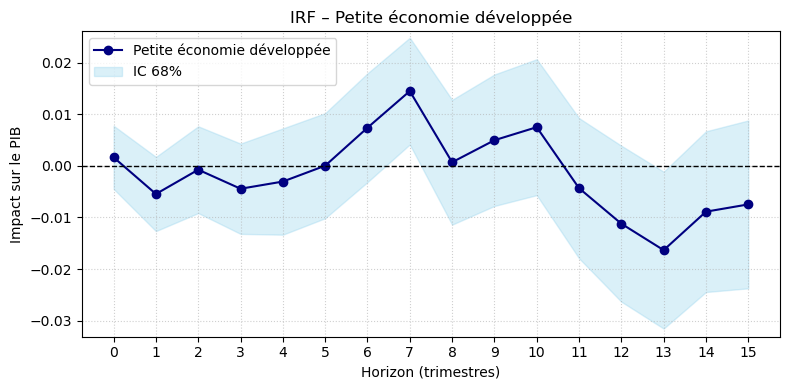

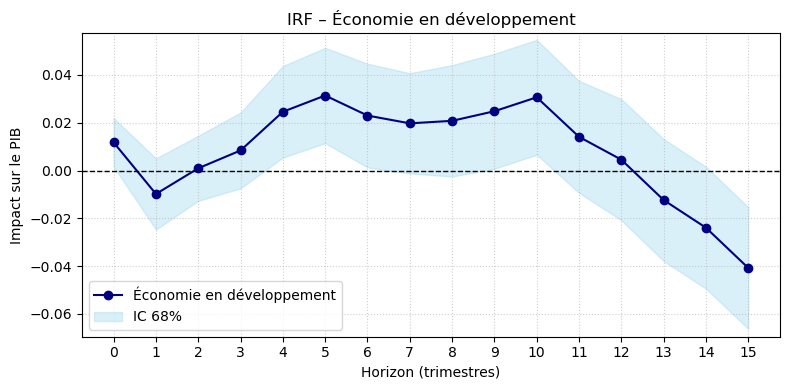

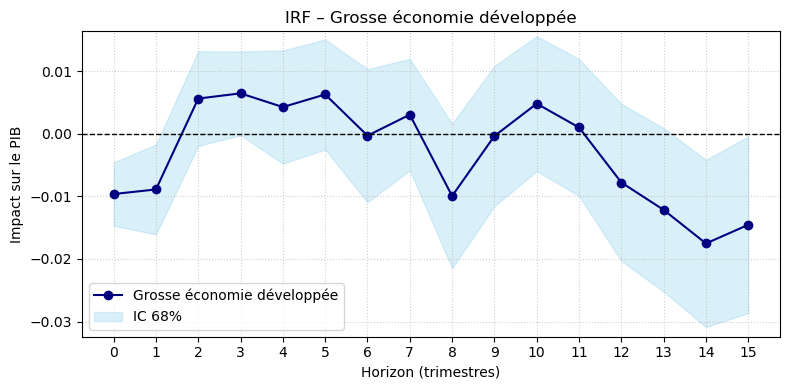

In [194]:
for cat in results_irf_cat:
    irf = results_irf_cat[cat]
    ci = np.array(conf_ints_cat[cat])
    
    # Vérifie que des données existent
    if all(np.isnan(irf)):
        print(f"⏭️  Pas assez de données pour {cat}")
        continue

    lower, upper = ci[:, 0], ci[:, 1]

    # Définir des bornes dynamiques
    y_min = np.nanmin(lower) - 0.05 * abs(np.nanmin(lower))
    y_max = np.nanmax(upper) + 0.05 * abs(np.nanmax(upper))

    # Tracé
    plt.figure(figsize=(8, 4))
    plt.plot(horizons, irf, marker='o', color='navy', label=cat)
    plt.fill_between(horizons, lower, upper, color='skyblue', alpha=0.3, label="IC 68%")
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    # Axes et titre
    plt.title(f"IRF – {cat}")
    plt.xlabel("Horizon (trimestres)")
    ylabel = "Impact sur log(PIB)" if not percentage_output else "Impact sur le PIB"
    plt.ylabel(ylabel)
    plt.ylim(y_min, y_max)
    plt.xticks(horizons)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
